# Introduction

This notebook backtests 500 stock tickers. After reading in the stock tickers from a CSV file, it calls `backtester()` to do all the hard work. This is basically a wrapper for the `backtester()`. The `backtester()` is stored in backtest.py.

In [1]:
from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [4]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}stocks_500.csv')
idx = (sdf.TICKER > '')
sdf = sdf.loc[idx].reset_index()
tickers = sdf.TICKER.to_list()

In [5]:
print(len(tickers), tickers)

483 ['ARAY', 'AYI', 'ADUS', 'IOTS', 'ADRO', 'AAP', 'WMS', 'ARPO', 'AES', 'AGCO', 'AGRX', 'ALRN', 'AIRT', 'AKRX', 'ALK', 'AA', 'AXU', 'ALXN', 'AQN', 'ALGN', 'ALLK', 'ABTX', 'AMRK', 'AEP', 'AFG', 'AMNB', 'AMT', 'AMWD', 'AMP', 'AMGN', 'FOLD', 'AMPH', 'PLAN', 'ATRS', 'ACRE', 'AGX', 'ARMP', 'ARWR', 'AIZ', 'ALOT', 'AAME', 'ATO', 'ATRC', 'ACB', 'ADP', 'AVB', 'AGR', 'AVY', 'AVA', 'BW', 'BTN', 'TBBK', 'BAC', 'BOCH', 'BPRN', 'BRN', 'BSET', 'BTE', 'BCBP', 'BASI', 'BPTH', 'BB', 'BKH', 'BMCH', 'BA', 'BOOT', 'BPFH', 'BXP', 'EPAY', 'BDGE', 'BCOV', 'BFAM', 'BHF', 'BRT', 'BLDR', 'BFST', 'CAMP', 'CPB', 'CNQ', 'CBNK', 'CCBG', 'COF', 'CFFN', 'CDLX', 'CSL', 'KMX', 'CARO', 'CASS', 'CBZ', 'CBL', 'CBMB', 'CM', 'CNP', 'CHRA', 'CTHR', 'CRL', 'CCF', 'CHEF', 'CHE', 'CHMI', 'CVX', 'CMRX', 'CAAS', 'CCRC', 'CXDC', 'CYD', 'CHD', 'CHUY', 'CINF', 'CTRN', 'CFG', 'CHCO', 'CLFD', 'CMS', 'JVA', 'COLM', 'CMCO', 'CBSH', 'COMM', 'JCS', 'CBU', 'TCFC', 'CRK', 'CAG', 'TCS', 'CORT', 'CPLG', 'COST', 'ICBK', 'CVIA', 'BREW', 'CRAI',

In [6]:
%time myPnL_df, my_Capital_df, possible_trades_df, buy_opportunities_df = backtester("backtest_0500.log", tickers, "10y", 10000, 5)

Simulating 457 stocks



local minima and maxima: 100%|██████████| 457/457 [03:28<00:00,  2.19it/s]



Unable to determine local minima and maxima for the following tickers:
['GS', 'WCN']
Simulating with remaining 455 stocks



possible trades: 100%|██████████| 455/455 [09:51<00:00,  1.30s/it]



Possible trades to simulate: 4659
Trading days to simulate   : 740



simulate trades: 100%|██████████| 740/740 [03:02<00:00,  4.05it/s]


Today's buying recommendations:

    ticker   buy_date  buy_close  trading_days  gain_pct  daily_return
129   DENN 2020-02-26      18.39     18.562500  1.894375      0.403125
147    ETR 2020-02-26     125.65     15.142857  2.019286      0.374286
104   CBSH 2020-02-26      64.56     22.857143  3.495714      0.297857
288     PH 2020-02-26     189.67     15.352941  0.591765      0.263529
228    KRC 2020-02-26      79.39     23.545455  3.129091      0.239091


Yesterday's buying recommendations:

    ticker   buy_date  buy_close  trading_days   gain_pct  daily_return
153   EXAS 2020-02-25      86.54     14.529412  10.650000      2.135882
391   PRTS 2020-02-25       2.38     19.842105   2.602105      1.104211
25    AMWD 2020-02-25      98.47     24.928571   2.857857      0.827143
2     ADUS 2020-02-25      93.62      6.842105   2.187895      0.690526
318     RF 2020-02-25      14.79     15.416667   1.987917      0.475833

CPU times: user 28min 1s, sys: 8.06 s, total: 28min 9s
Wall time: 16

# Summary Chart

This chart provides an overview of well the backtest went and how it increased or decreased the initial capital over time.

In [7]:
idx = myPnL_df.action=='BUY'
first_buy_date = myPnL_df.loc[idx].date.min()
first_buy_date

Timestamp('2017-03-23 00:00:00')

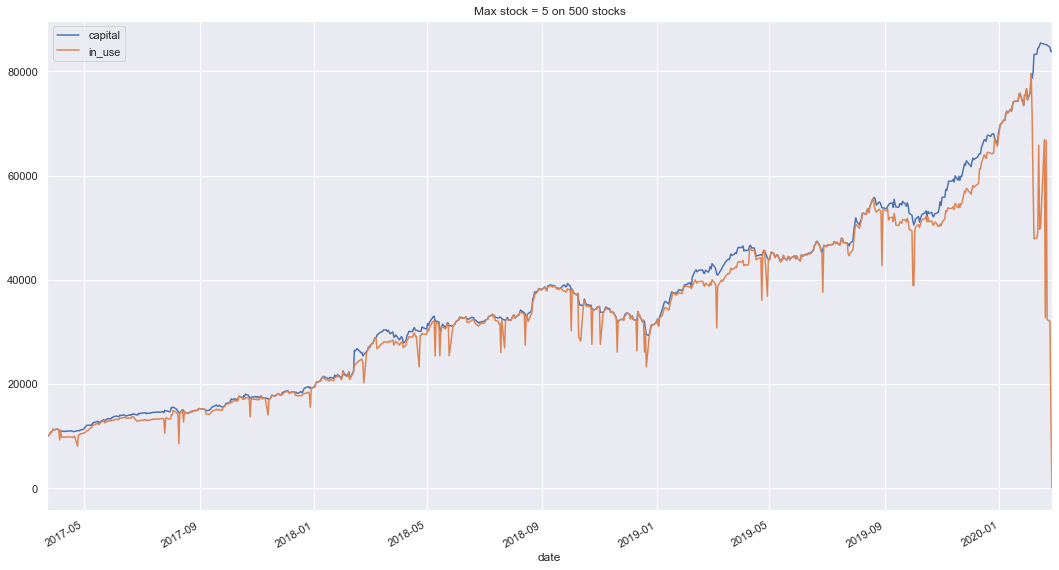

In [8]:
#myPnL_df, my_Capital_df = backtester()
myCapital_df = my_Capital_df
myCapital_df.index = myCapital_df.date
to_plot_cols = ['capital', 'in_use']
myCapital_df[to_plot_cols][first_buy_date:].plot(figsize=(18,10))
plt.title('Max stock = 5 on 500 stocks')
plt.show()

# Analysis of Results

The cells below perform a simple analysis. They look at the completed trades. For each trade it calculates the gain and gain percentage. With that it then displays the top ten losses and top ten gains. It ends with calculating the percentage of trades that resulted in a loss.

In [9]:
sell_df = myPnL_df[myPnL_df.action=='SELL'].copy()
sell_df['gain'] = (sell_df.close_amount - sell_df.orig_amount)
sell_df['gain_pct'] = round((sell_df.gain / sell_df.orig_amount)*100, 2)
sell_df['daily_comp_pct'] = (((1 + sell_df.gain_pct/100) ** (1/ sell_df.days_in_trade)) - 1)*100
sell_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-03-23,NM,SELL,2000.000000,2000.000000,123.456790,14.580,0.000000e+00,0.000000e+00,1,0,0.000000e+00,0.00,0.000000
0,2017-03-23,MNTA,SELL,2000.000000,2000.000000,149.253731,12.060,2.273737e-13,1.136868e-14,1,0,2.273737e-13,0.00,0.000000
0,2017-03-23,OSBC,SELL,2000.000000,2000.000000,193.986421,9.279,0.000000e+00,0.000000e+00,1,0,0.000000e+00,0.00,0.000000
0,2017-03-23,NATR,SELL,2000.000000,2000.000000,210.526316,8.550,-2.273737e-13,-1.136868e-14,1,0,-2.273737e-13,-0.00,0.000000
0,2017-03-23,HBMD,SELL,2000.000000,2000.000000,115.874855,15.534,0.000000e+00,0.000000e+00,1,0,0.000000e+00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-19,FFBC,SELL,17092.407967,17057.497003,698.219280,22.032,-3.491096e+01,-2.042484e-01,2,0,-3.491096e+01,-0.20,-0.100050
0,2020-02-21,FCAP,SELL,16914.437764,17308.980707,254.543834,59.805,1.374537e+02,8.004744e-01,7,0,3.945429e+02,2.33,0.329580
0,2020-02-21,HFWA,SELL,17031.224627,16986.806381,634.546372,24.156,-4.441825e+01,-2.608048e-01,2,0,-4.441825e+01,-0.26,-0.130085
0,2020-02-25,CCBG,SELL,17031.224627,16168.077529,579.293355,26.460,-2.838537e+02,-1.725352e+00,4,0,-8.631471e+02,-5.07,-1.292337


In [10]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 0
Data columns (total 14 columns):
date              519 non-null datetime64[ns]
ticker            519 non-null object
action            519 non-null object
orig_amount       519 non-null float64
close_amount      519 non-null float64
no_shares         519 non-null float64
stop_loss         519 non-null float64
daily_gain        519 non-null float64
daily_pct         519 non-null float64
days_in_trade     519 non-null int64
invested          519 non-null int64
gain              519 non-null float64
gain_pct          519 non-null float64
daily_comp_pct    519 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 60.8+ KB


In [11]:
sell_df.describe()

,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
count,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.0,519.000000,519.000000,519.000000
mean,6205.952353,6348.316644,995.977462,42.524809,14.284721,0.247073,7.973025,0.0,142.364291,2.368478,0.159361
std,3263.356961,3430.054448,3475.477666,55.194632,294.962150,5.035285,16.275477,0.0,793.375493,11.460510,1.106770
min,1794.594595,1794.594595,9.464722,0.171000,-1158.289177,-20.183486,1.000000,0.0,-1579.485241,-25.640000,-4.499411
25%,3414.727158,3444.408199,81.977538,7.650000,-35.363580,-0.705330,1.000000,0.0,-19.766872,-0.385000,-0.103825
50%,6040.390626,6174.783625,221.724029,22.500000,0.000000,0.000000,3.000000,0.0,0.000000,0.000000,0.000000
75%,7794.778090,8031.834914,721.583244,54.666000,36.741270,0.712345,7.000000,0.0,142.081629,2.270000,0.410667
max,17092.407967,22951.800662,57115.561623,563.562000,3554.514345,86.956522,166.000000,0.0,11789.925238,105.630000,8.508064


In [12]:
sell_df.sort_values(by='gain_pct', ascending=True)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2018-05-15,ENT,SELL,6159.992440,4580.507199,5264.950803,1.053,-1158.289177,-20.183486,12,0,-1579.485241,-25.64,-2.438542
0,2018-11-20,ROST,SELL,6777.664339,5720.976965,70.118605,86.994,-591.801024,-9.374653,5,0,-1056.687374,-15.59,-3.332880
0,2019-04-29,NOVN,SELL,8620.833466,7347.301249,9796.401666,0.792,-1077.604183,-12.790698,4,0,-1273.532217,-14.77,-3.916653
0,2017-11-13,IMMR,SELL,3476.883166,2988.185093,509.060493,6.147,-183.261777,-5.778491,6,0,-488.698073,-14.06,-2.493727
0,2018-08-14,ENPH,SELL,6267.834248,5392.259447,1067.774148,5.283,-341.687727,-5.959032,6,0,-875.574801,-13.97,-2.476715
0,2019-10-01,ODT,SELL,10763.141969,9308.560680,379.786237,25.506,-577.275081,-5.839416,21,0,-1454.581289,-13.51,-0.688767
0,2017-08-10,ISNS,SELL,2946.236210,2556.293182,866.540062,3.060,-129.981009,-4.838710,7,0,-389.943028,-13.24,-2.008477
0,2019-10-02,REKR,SELL,11009.042083,9573.080072,4786.540036,2.070,-574.384804,-5.660377,8,0,-1435.962011,-13.04,-1.731361
0,2019-08-29,ZN,SELL,10981.299456,9564.357591,35423.546633,0.279,-708.470933,-6.896552,3,0,-1416.941865,-12.90,-4.499411
0,2017-10-17,USIO,SELL,3301.849184,2881.613833,2001.120717,1.485,-220.123279,-7.096774,3,0,-420.235351,-12.73,-4.437319


In [13]:
sell_df.sort_values(by='gain_pct', ascending=False)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2020-02-05,ENPH,SELL,11161.875423,22951.800662,621.831500,16.155,6.218315,0.027100,64,0,11789.925238,105.63,1.132787
0,2018-03-09,ENPH,SELL,4201.297285,8380.938398,2165.617157,1.746,173.249373,2.110818,36,0,4179.641113,99.48,1.936692
0,2018-02-13,ZN,SELL,3838.875493,7642.205843,1777.257173,1.944,3554.514345,86.956522,31,0,3803.330350,99.07,2.245770
0,2017-04-07,SYX,SELL,1985.851498,3338.589945,393.237920,4.545,31.459034,0.951249,11,0,1352.738446,68.12,4.836099
0,2019-09-05,MEDP,SELL,8385.417587,13297.404581,160.732559,46.953,215.381629,1.646394,128,0,4911.986994,58.58,0.360875
0,2018-09-24,EXAS,SELL,5746.583394,8764.012715,111.303184,46.467,273.805833,3.224961,37,0,3017.429320,52.51,1.147233
0,2017-06-26,NVDA,SELL,2167.689033,3260.608802,21.607746,90.288,-35.868858,-1.088096,47,0,1092.919770,50.42,0.872424
0,2019-02-04,ENPH,SELL,5856.260634,8215.195278,1173.599325,4.491,0.000000,0.000000,27,0,2358.934644,40.28,1.261484
0,2019-02-26,NEWR,SELL,6481.589019,8807.114712,83.471848,69.885,-27.545710,-0.311791,61,0,2325.525693,35.88,0.503891
0,2019-10-28,NXRT,SELL,8538.104210,11591.465981,245.842333,31.257,19.667387,0.169960,159,0,3053.361771,35.76,0.192461


In [14]:
sell_df[sell_df.gain_pct < 0].count()[0], sell_df[sell_df.gain_pct < 0].count()[0]/len(sell_df)

(145, 0.279383429672447)

In [15]:
myPnL_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested
0,2017-03-23,NATR,BUY,2000.000000,2000.000000,210.526316,8.550,0.000000,0.000000,0,0
0,2017-03-23,MNTA,BUY,2000.000000,2000.000000,149.253731,12.060,0.000000,0.000000,0,0
0,2017-03-23,TDG,BUY,2000.000000,2000.000000,11.502847,156.483,0.000000,0.000000,0,0
0,2017-03-23,ICFI,BUY,2000.000000,2000.000000,49.714144,36.207,0.000000,0.000000,0,0
0,2017-03-23,NM,BUY,2000.000000,2000.000000,123.456790,14.580,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-24,NXRT,CLOSE,13356.433383,15498.995884,307.397776,39.105,58.405578,0.378260,45,0
0,2020-02-24,CCBG,CLOSE,17031.224627,16451.931272,579.293355,26.460,-469.227617,-2.773023,3,0
0,2020-02-25,CCBG,SELL,17031.224627,16168.077529,579.293355,26.460,-283.853744,-1.725352,4,0
0,2020-02-25,NXRT,CLOSE,13356.433383,14939.531931,307.397776,39.105,-559.463953,-3.609679,46,0


In [16]:
sell_df.ticker.unique(), len(sell_df.ticker.unique())

(array(['NM', 'MNTA', 'OSBC', 'NATR', 'HBMD', 'SFST', 'SYNA', 'CBSH',
        'ICFI', 'TDG', 'AMGN', 'GCO', 'CVI', 'EXAS', 'IMMR', 'ARWR', 'SYX',
        'ISSC', 'CMS', 'MBI', 'ROST', 'DPZ', 'JCS', 'RCL', 'CVX', 'EDSA',
        'ZN', 'WOR', 'ISNS', 'GFN', 'MSEX', 'HLIT', 'THG', 'CORT', 'FHB',
        'VSH', 'TNAV', 'OTEX', 'RNST', 'PEG', 'CREE', 'KRA', 'ADUS',
        'MTSC', 'STRL', 'FICO', 'VZ', 'GMO', 'FLNT', 'COST', 'LAWS',
        'NSYS', 'ITT', 'NVDA', 'ETR', 'POWL', 'RF', 'DSGX', 'BREW', 'NAV',
        'JBSS', 'WEC', 'AES', 'CRK', 'ADP', 'AMT', 'VIAV', 'CRL', 'CFR',
        'TRNS', 'NOA', 'HWC', 'AMWD', 'CASS', 'EOG', 'ROP', 'ALOT', 'BTE',
        'ARAY', 'CTRN', 'PCTI', 'ENT', 'YUM', 'RGEN', 'CTHR', 'KIRK',
        'WINA', 'WMT', 'PRAA', 'AEP', 'DRI', 'USIO', 'TR', 'FISV', 'TRIP',
        'MDP', 'NSIT', 'SLG', 'WMS', 'BASI', 'COF', 'BAC', 'EBF', 'KAI',
        'ATRS', 'ROK', 'CHEF', 'PRSC', 'HTBI', 'AGCO', 'PSMT', 'CHCO',
        'CUBE', 'TWIN', 'SUPN', 'PANW', 'IDCC', 'BRT', '

In [17]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
64,ENPH,17452.926194
69,EXAS,6577.289479
20,ARWR,5662.508489
121,MEDP,4911.986994
183,SYX,4870.880317
138,NXRT,4740.975563
189,TNAV,3473.321990
137,NVDA,3402.132340
131,NOA,2326.292275
129,NEWR,2325.525693


In [18]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
139,ODT,-1454.581289
159,REKR,-1435.962011
132,NOVN,-1273.532217
65,ENT,-1118.400618
9,AGRX,-1111.426177
180,SYF,-960.513999
37,CCBG,-863.147098
146,PCTY,-779.546331
201,WAT,-737.222415
182,SYNC,-731.024711


In [19]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
121,MEDP,4911.986994
64,ENPH,4363.231549
138,NXRT,2370.487781
129,NEWR,2325.525693
85,GWRS,2159.387873
189,TNAV,1736.660995
30,BPRN,1473.126951
204,WING,1307.041687
131,NOA,775.430758
14,AMPH,700.944078


In [20]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
139,ODT,-1454.581289
159,REKR,-1435.962011
132,NOVN,-1273.532217
37,CCBG,-863.147098
146,PCTY,-779.546331
9,AGRX,-555.713088
180,SYF,-320.171333
65,ENT,-279.600154
182,SYNC,-243.674904
117,LUNA,-170.741214


In [21]:
myCapital_df.tail()

,date,capital,in_use,free
date,,,,
2020-02-20,2020-02-20,85149,66769.9,18379.2
2020-02-21,2020-02-21,85036.7,32361.7,52674.9
2020-02-24,2020-02-24,84625.9,31950.9,52674.9
2020-02-25,2020-02-25,83782.6,14939.5,68843
2020-02-26,2020-02-26,83887.1,0,83887.1


In [22]:
len(possible_trades_df)

4659

In [23]:
possible_trades_df.to_csv(f'{DATAPATH}possible_trades_0500.csv', index=False)
myCapital_df.to_csv(f'{DATAPATH}capital_0500.csv', index=False)
myPnL_df.to_csv(f'{DATAPATH}PnL_0500.csv', index=False)

In [24]:
ls ../data

F13_Renaissance_tech.csv  capital_0500.csv          possible_trades_1000.csv
F13_Renaissance_tech.txt  capital_1000.csv          possible_trades_1500.csv
PnL_0100.csv              capital_1500.csv          possible_trades_2000.csv
PnL_0500.csv              capital_2000.csv          stocks.csv
PnL_1000.csv              exclude.csv               stocks_100.csv
PnL_1500.csv              optimal_params.csv        stocks_1000.csv
PnL_2000.csv              possible_trades_0100.csv  stocks_2000.csv
capital_0100.csv          possible_trades_0500.csv  stocks_500.csv
